In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import load_model
from keras.saving import register_keras_serializable
import keras

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cv2

In [47]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))


In [4]:
def load_images(noisy_dir, clean_dir, test_dir, target_size=(540, 540)):
    noisy_images = []
    clean_images = []
    test_images = []

    filenames = os.listdir(noisy_dir)

    for filename in filenames:

        noisy_path = os.path.join(noisy_dir, filename)
        noisy_img = cv2.imread(noisy_path, cv2.IMREAD_GRAYSCALE)
        noisy_img = cv2.resize(noisy_img, target_size)
        noisy_img = noisy_img.astype('float32') / 255.0  

        clean_path = os.path.join(clean_dir, filename)
        clean_img = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE)
        clean_img = cv2.resize(clean_img, target_size)
        clean_img = clean_img.astype('float32') / 255.0

        noisy_images.append(noisy_img)
        clean_images.append(clean_img)

    filenames_test = os.listdir(test_dir)

    for filename in filenames_test:
        test_path = os.path.join(test_dir, filename)
        test_image = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
        test_image = cv2.resize(test_image, target_size)
        test_image = test_image.astype('float32') / 255.0

        test_images.append(test_image)

    return np.array(noisy_images), np.array(clean_images), np.array(test_images)

In [5]:
X_train, y_train, X_test = load_images('D:/Documents/Production_practice/denoising-dirty-documents/train/',
                               'D:/Documents/Production_practice/denoising-dirty-documents/train_cleaned/',
                               'D:/Documents/Production_practice/denoising-dirty-documents/test/')

In [40]:
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [45]:
autoencoder = load_model('autoencoder.keras')
autoencoder_bce = load_model('autoencoder_bce.keras')
autoencoder_bce_2 = load_model('autoencoder_bce_2.keras')
autoencoder_ssim = load_model(
    'autoencoder_ssim.keras',
    custom_objects={'Custom>ssim_loss': ssim_loss}
)

## Визуальное сравнение четырех моделей

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step


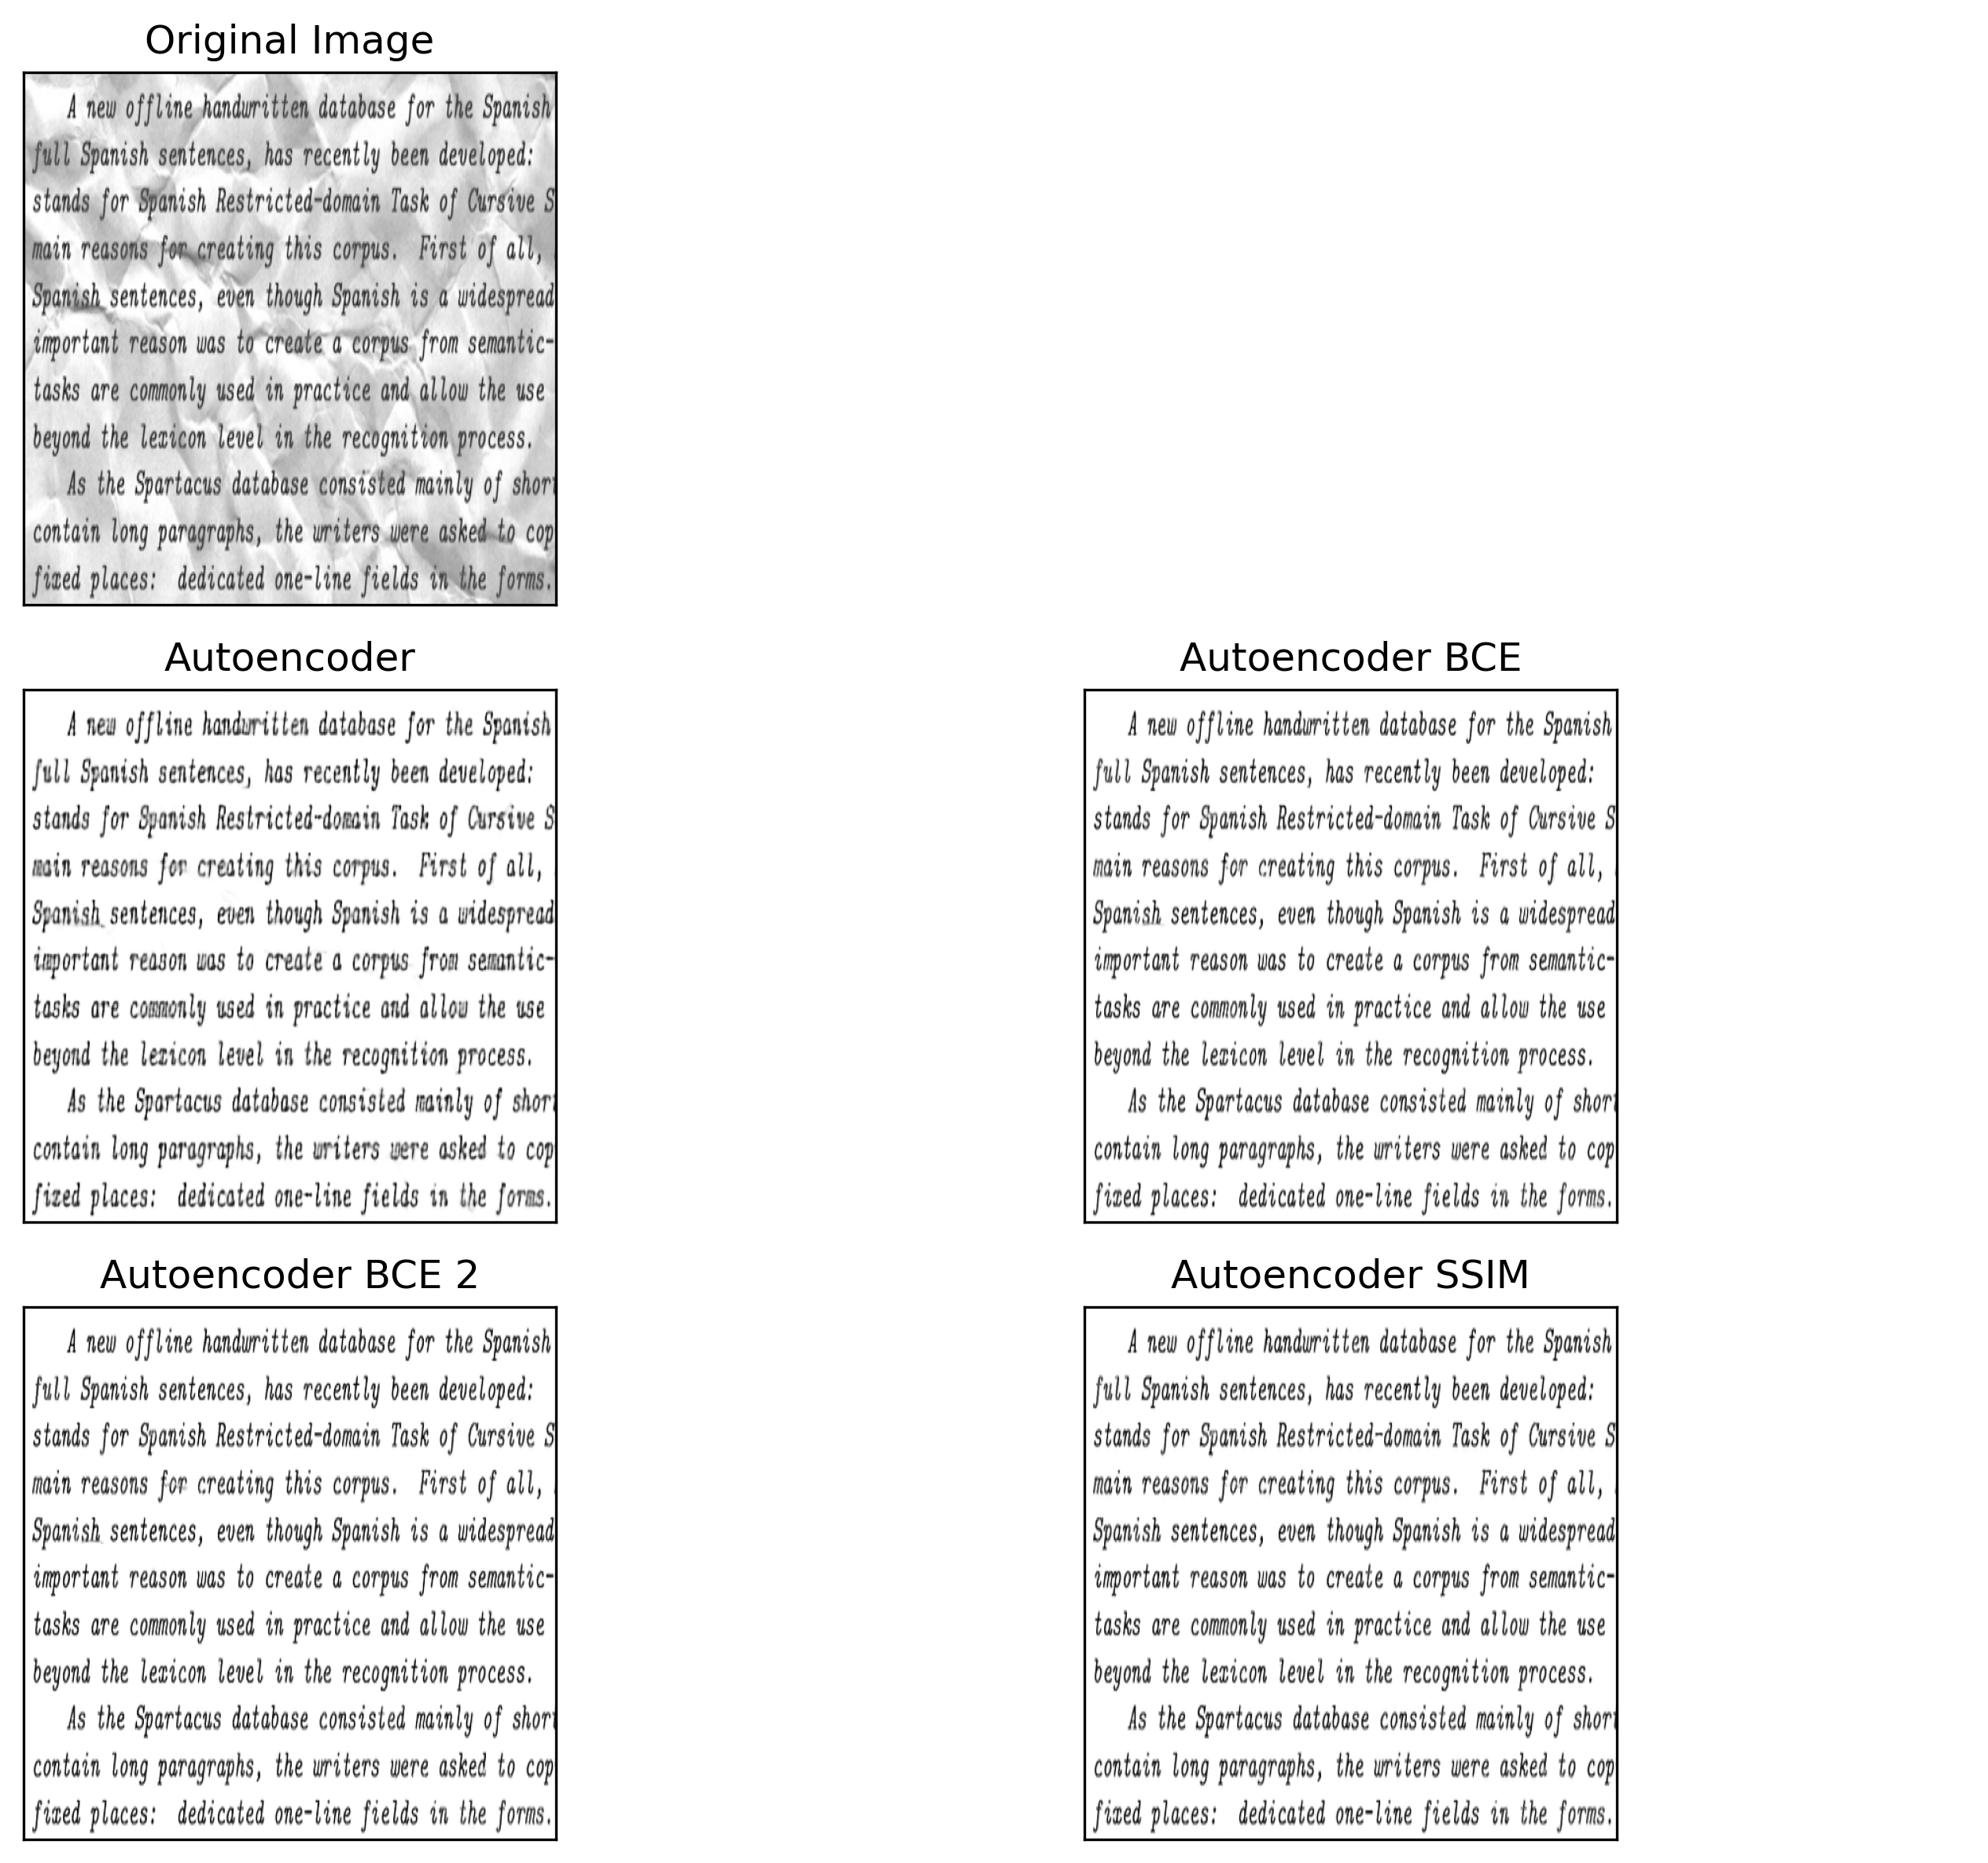

In [46]:
i = np.random.randint(0, len(X_test))
original = X_test[i:i+1]

pred_ae = autoencoder.predict(original)
pred_ae_bce = autoencoder_bce.predict(original)
pred_ae_bce_2 = autoencoder_bce_2.predict(original)
pred_ae_ssim = autoencoder_ssim.predict(original)

plt.figure(dpi=300, figsize=(10, 8))

ax = plt.subplot(3, 2, 1)
plt.imshow(original.squeeze(), cmap='gray')
plt.title("Original Image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(3, 2, 2)
ax.axis('off')

ax = plt.subplot(3, 2, 3)
plt.imshow(pred_ae.squeeze(), cmap='gray')
plt.title("Autoencoder")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(3, 2, 4)
plt.imshow(pred_ae_bce.squeeze(), cmap='gray')
plt.title("Autoencoder BCE")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(3, 2, 5)
plt.imshow(pred_ae_bce_2.squeeze(), cmap='gray')
plt.title("Autoencoder BCE 2")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(3, 2, 6)
plt.imshow(pred_ae_ssim.squeeze(), cmap='gray')
plt.title("Autoencoder SSIM")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.tight_layout()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


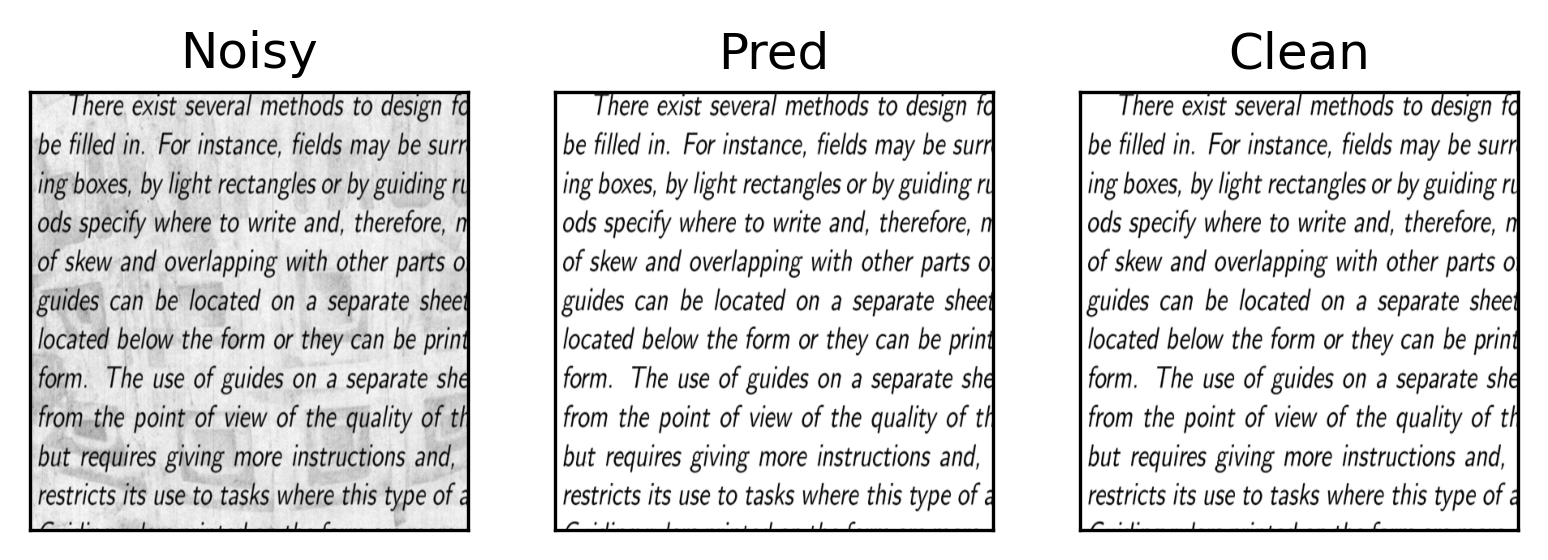

In [26]:
i = np.random.randint(0, 144)
pred = autoencoder_ssim.predict(X_train[i:i+1])
clean = y_train[i]

plt.figure(dpi=300)

ax = plt.subplot(1, 3, 1)
plt.imshow(X_train[i].squeeze(), cmap='gray')
plt.title("Noisy")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 3, 2)
plt.imshow(pred.squeeze(), cmap='gray')
plt.title("Pred")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 3, 3)
plt.imshow(clean.squeeze(), cmap='gray')
plt.title("Clean")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Очистка любого изображения с текстом

In [24]:
def denoise_image(img_dir, model, target_size=(540, 540)):
    img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    images = np.array([img])
    return model.predict(images)

In [ ]:
img = denoise_image(r'D:\Downloads\text-photographed.jpg', autoencoder_ssim)
ax = plt.imshow(img.squeeze(), cmap='gray')
